# **Test Meshing**

Question: once we actually have a network $SDF(\{x,y,x\})$ that gives SDF values for query points - how do we viusalize and represent the results?

Option for testing/development - just define a "dummy" SDF network to be a function that represents geometry of sphere. Here's a cool summary of SDF functions for various object: [website](https://iquilezles.org/articles/distfunctions/)

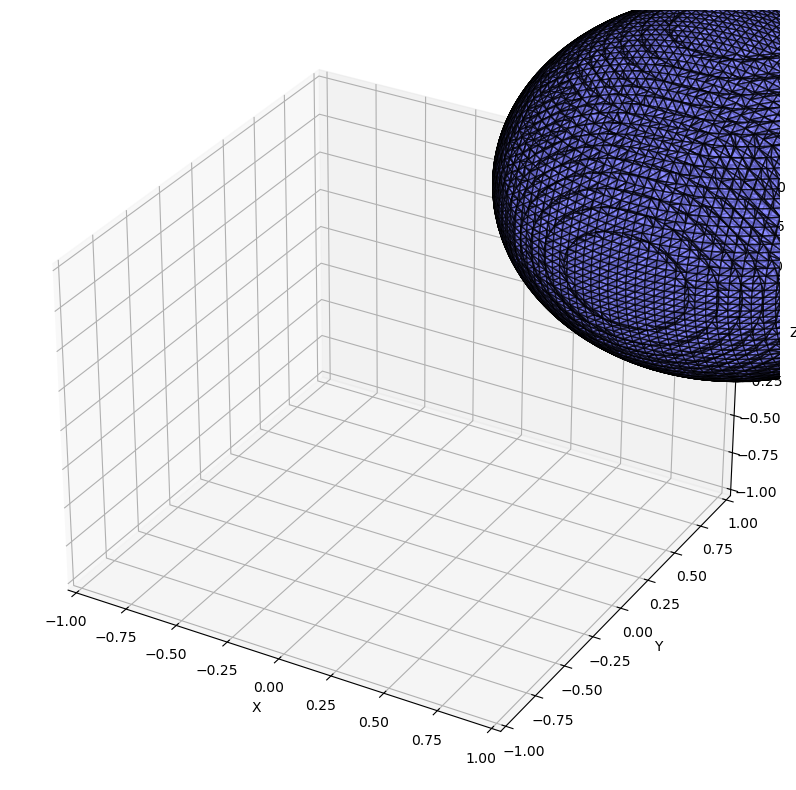

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Example: Create a simple SDF for a sphere on a grid
# Define grid dimensions and sphere parameters
nx, ny, nz = 50, 50, 50
xmin, xmax = -1, 1
ymin, ymax = -1, 1
zmin, zmax = -1, 1

# Create coordinate grids
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
z = np.linspace(zmin, zmax, nz)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Define SDF for a sphere with radius 0.5 centered at the origin
sdf = np.sqrt(X**2 + Y**2 + Z**2) - 1

# Set the spacing for marching cubes based on the grid resolution
dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dz = (zmax - zmin) / (nz - 1)

# Use marching cubes to extract the surface at sdf=0 (zero level set)
verts, faces, normals, values = measure.marching_cubes(sdf, level=0.0, spacing=(dx, dy, dz))

# Plotting the resulting mesh
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a Poly3DCollection from the vertices and faces
mesh = Poly3DCollection(verts[faces], alpha=0.7)
mesh.set_facecolor([0.5, 0.5, 1])  # light blue
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

# Set plot limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.set_zlim(zmin, zmax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.tight_layout()
plt.show()

### **Make SDF Dataset**

In [8]:
import os
import numpy as np
import point_cloud_utils as pcu

# Path to the bench category as an example
CATEGORY_ID = "02946921"
category_path = "C:/Users/lukas/OneDrive - Yale University/Personal/Studies/Semester 4/CPSC 452/Project/Code/data/{}".format(CATEGORY_ID)

# Resolution used to convert shapes to watertight manifolds
# Higher value means better quality and slower
manifold_resolution = 20_000

# Number of points in the volume to sample around the shape
num_vol_pts = 100_000

# Number of points on the surface to sample
num_surf_pts = 100_000

for model_path in os.listdir(category_path)[0:1]:  # Only process the first model for demonstration
    v, f = pcu.load_mesh_vf(os.path.normpath(os.path.join(category_path, model_path, "models", "model_normalized.obj")))

    # Convert mesh to watertight manifold
    vm, fm = pcu.make_mesh_watertight(v, f, manifold_resolution)
    nm = pcu.estimate_mesh_vertex_normals(vm, fm)  # Compute vertex normals for watertight mesh

    # Generate random points in the volume around the shape
    # NOTE: ShapeNet shapes are normalized within [-0.5, 0.5]^3
    p_vol = (np.random.rand(num_vol_pts, 3) - 0.5) * 1.1

    # Compute the SDF of the random points
    sdf, _, _  = pcu.signed_distance_to_mesh(p_vol, vm, fm)

    # Sample points on the surface as face ids and barycentric coordinates
    fid_surf, bc_surf = pcu.sample_mesh_random(vm, fm, num_surf_pts)

    # Compute 3D coordinates and normals of surface samples
    p_surf = pcu.interpolate_barycentric_coords(fm, fid_surf, bc_surf, vm)
    n_surf = pcu.interpolate_barycentric_coords(fm, fid_surf, bc_surf, nm)

    # Save volume points + SDF and surface points + normals
    # Load using np.load()
    npz_path = os.path.join(category_path, model_path, "samples.npz")
    
    np.savez(npz_path, p_vol=p_vol, sdf_vol=sdf, p_surf=p_surf, n_surf=n_surf)

In [9]:
# load the saved data
data = np.load(os.path.join(category_path, model_path, "samples.npz"))
p_vol = data['p_vol']
sdf_vol = data['sdf_vol']
p_surf = data['p_surf']
n_surf = data['n_surf']


In [12]:
# do the same operations but in pytorch
import torch

for model_path in os.listdir(category_path)[0:1]:  # Only process the first model for demonstration
    v, f = pcu.load_mesh_vf(os.path.normpath(os.path.join(category_path, model_path, "models", "model_normalized.obj")))

    # Convert mesh to watertight manifold
    vm, fm = pcu.make_mesh_watertight(v, f, manifold_resolution)
    nm = pcu.estimate_mesh_vertex_normals(vm, fm)  # Compute vertex normals for watertight mesh

    # Generate random points in the volume around the shape
    # NOTE: ShapeNet shapes are normalized within [-0.5, 0.5]^3
    p_vol = (np.random.rand(num_vol_pts, 3) - 0.5) * 1.1

    # Compute the SDF of the random points
    sdf, _, _  = pcu.signed_distance_to_mesh(p_vol, vm, fm)

    # Sample points on the surface as face ids and barycentric coordinates
    fid_surf, bc_surf = pcu.sample_mesh_random(vm, fm, num_surf_pts)

    # Compute 3D coordinates and normals of surface samples
    p_surf = pcu.interpolate_barycentric_coords(fm, fid_surf, bc_surf, vm)
    n_surf = pcu.interpolate_barycentric_coords(fm, fid_surf, bc_surf, nm)

    # Save volume points + SDF and surface points + normals
    # Load using np.load()
    # Optionally, move tensors to a specific device
    
    vm_tensor    = torch.tensor(vm, dtype=torch.float32)
    fm_tensor    = torch.tensor(fm, dtype=torch.int64)
    nm_tensor    = torch.tensor(nm, dtype=torch.float32)
    p_vol_tensor = torch.tensor(p_vol, dtype=torch.float32)
    sdf_tensor   = torch.tensor(sdf, dtype=torch.float32)
    p_surf_tensor = torch.tensor(p_surf, dtype=torch.float32)
    n_surf_tensor = torch.tensor(n_surf, dtype=torch.float32)
    
    # Create a dictionary to hold the torch tensors
    data = {
        'vertices': vm_tensor,
        'faces': fm_tensor,
        'normals': nm_tensor,
        'volume_points': p_vol_tensor,
        'sdf': sdf_tensor,
        'surface_points': p_surf_tensor,
        'surface_normals': n_surf_tensor,
    }
    
    out_dir = "C:\Users\lukas\OneDrive - Yale University\Personal\Studies\Semester 4\CPSC 452\Project\Code\out"
    
    # Save the dictionary using torch.save (the file extension '.pt' is common for torch files)
    out_file = os.path.join(out_dir, f"{model_id}_data.pt")
    torch.save(data, out_file)
    print(f"Saved processed data for model {model_id} to {out_file}")

NameError: name 'out_dir' is not defined